<a href="https://colab.research.google.com/github/pipeton8/6.439-stats-comp-applications/blob/main/Assignments/4%20-%20Networks/6.439%20-%20Problem%20Set%204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 4 - Statistics, Computation and Applications

(c) Felipe del Canto, November 2021
***
***

_Note: The dataset for this assignment was provided for in class use only. For this reason, this notebook will not run. I will try to provide a toy dataset in the future._

# Part 0 (Execute first!)

In [38]:
# Import packages
import scipy
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

import seaborn           as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

# Problem 4.2: Co-offending Network

## Preamble

In [47]:
# Load data
co_off = pd.read_csv("Cooffending.csv")

# Set date
co_off['date'] = pd.to_datetime(co_off['date'])

# Set crime codes, counties and locations as categorical
categorical_vars = (['offender_id', 'sex', 'event_id'] 
                    + [f'crime{k}_code' for k in range(1,5)] 
                    + ['county', 'location'])
co_off[categorical_vars] = co_off[categorical_vars].astype('category')

## (a), (b), (c), (d): Data exploration

This dataset contains 1,279,009 entries. Each observation is taken at the `offender_id`-`event_id` level, this is, individual offenders arrested at a given crime event.





In [48]:
co_off.shape[0]

1279009

Within, the number of unique offenders is 538,847, and the number of different crime events are 1,163,423, which occurred between 2003 and 2010 according to the following table:

| Year | Number of arrests |
|:--:|:--:|
| 2003 |  122,281 |
| 2004 |  133,698 |
| 2005 |  188,007 |
| 2006 |  203,229 |
| 2007 |  213,995 |
| 2008 |  220,452 |
| 2009 |  197,340 |
| 2010 |        7 |

In [52]:
co_off[['offender_id', 'event_id']].describe(include='all')

,offender_id,event_id
count,1279009,1279009
unique,538847,1163423
top,300728,27849
freq,456,156


In [55]:
co_off[['offender_id', 'year']].groupby(['year']).count()

,offender_id
year,
2003,122281
2004,133698
2005,188007
2006,203229
2007,213995
2008,220452
2009,197340
2010,7


We can observe a total of 294 different crime codes (different offenses).

In [61]:
co_off['crime1_code'].describe()

count     1279009
unique        294
top          1430
freq       138549
Name: crime1_code, dtype: int64

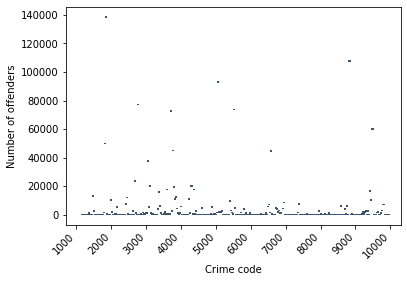

In [32]:
# Axis offsets
offset = (10,1000)
# Initialize figure
fig, ax = plt.subplots()

# Draw histplot using offender_id count as y-axis
sns.histplot(data=co_off[co_off['crime1_code'] != " "].groupby(['crime1_code']).count(), x='crime1_code', y='offender_id', ax = ax)

# Set xticks
xticks = [300/9 * k - 5 for k in range(10)]
xlabels = [1000 * k for k in range(1,11)]

plt.xticks(ticks=xticks, labels=xlabels, rotation=45, horizontalalignment = 'right')
plt.xlim(xticks[0] - offset[0], xticks[-1] + offset[0])

# Set yticks
yticks = [20000 * k for k in range(8)]
ylabels = yticks

plt.yticks(yticks, ylabels)

# Set axis titles
plt.xlabel("Crime code")
plt.ylabel("Number of offenders")

fig.show()

## (b)

## (c)

## (d)

## (e)

## (f)

## (g)

## (h)

## (i)

## (j)

## (k)

## (l)

## (m)